In [1]:
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2
import scipy


from datetime import datetime, date, time, timedelta
import numpy as np  ## Import the NumPy package
import matplotlib.pyplot as plt  ## import fundamental plotting library in Python
import seaborn as sns  ## Advanced plotting functionality with seaborn
sns.set(style="whitegrid") # can set style depending on how you'd like it to look

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats

import statsmodels.api as sm

import os

### Load Database

In [2]:
## Conect postgres to python
conn = psycopg2.connect(database="xxxxx", user = "xxxxx", password = "xxxxxh", host = "xxxxx",port="xxxx")
#conn = psycopg2.connect(database="kavak", user="postgres", password="2FaceCoin!")  #load database
cursor1=conn.cursor()

In [3]:
# Save Query into a dataframe

car_pageviews = pd.read_sql_query("select * from inv_dist.car_pageviews", conn)
showroom_visits = pd.read_sql_query("select a.*, b.name location_name from inv_dist.showroom_visits a LEFT JOIN inv_dist.showroom_id b on a.showroom_id=b.showroom_id", conn)  
showroom = pd.read_sql_query("select * from inv_dist.showroom_id", conn)
car_description = pd.read_sql_query(
    '''SELECT c.*, d.name brand_name, left(c.version,1) doors FROM
            (SELECT a.*, b.name location_name 
             FROM inv_dist.car_description a LEFT JOIN inv_dist.showroom_id b 
        ON a.sold_location_id=b.showroom_id) c
        LEFT JOIN inv_dist.brands d ON c.brand_id=d.brand_id
    ''', conn)



### Pageviews Stock_ID & Datetime Format

In [4]:
### Add stock_ID to the dataset for Pageviews table
car_pageviews['stock_id'] = car_pageviews['gmb_pagepath'].apply(lambda x: x[(x.rfind("autos-")+6):len(x)])

##Create date columns
car_pageviews['gmb_datetime'] = pd.to_datetime(car_pageviews['gmb_date'], format="%Y-%m-%d")
car_pageviews['year'] = car_pageviews['gmb_datetime'].dt.year
car_pageviews['month'] = car_pageviews['gmb_datetime'].dt.month
car_pageviews['my'] =pd.to_datetime(("01" + "/" + car_pageviews['month'].astype(str) + "/" + car_pageviews['year'].astype(str)), format="%d/%m/%Y")

### Sales aditional columns

In [5]:
import datetime

##Delete showroom equal to "FUERA DE KAVAK"
#car_description = car_description.drop(car_description[car_description['location_name']=="FUERA DE KAVAK"].index)
list_of_values = ['otro']
car_description = car_description.drop(car_description[car_description['location_name']=='otro'].index)


## Create new columns for numeric KAVAK SEGMENTS

a=('[ 79,999 - 209,999 ]','[ 212,999 - 339,999 ]','[ 342,999 - 1054,999 ]')
a=('[ 1,050 - 36,300 ]','[ 36,649 - 64,851 ]','[ 64,965 - 110,900 ]')
a=('Low','Mid','High')

car_description['new_price_segment'] = car_description['price_segment'].map({1: "[ 79,999 - 209,999 ]", 2: "[ 212,999 - 339,999 ]", 3: "[ 342,999 - 1054,999 ]"})
car_description['new_km_segment'] = car_description['km_segment'].map({1: "[ 1,050 - 36,300 ]", 2: "[ 36,649 - 64,851 ]", 3: "[ 64,965 - 110,900 ]"})
car_description['new_model_segment'] = car_description['model_segment'].map({1: "Low", 2: "Mid", 3: "High"})


##Create date columns
car_description['sold_datetime'] = pd.to_datetime(car_description['sold_date'], format="%Y-%m-%d")
car_description['sold_year'] = car_description['sold_datetime'].dt.year
car_description['sold_month'] = car_description['sold_datetime'].dt.month
car_description['sold_my'] =pd.to_datetime(("01" + "/" + car_description['sold_month'].astype(str) + "/" + car_description['sold_year'].astype(str)), format="%d/%m/%Y")


### Sum total pageviews per car ###

car_description['tot_pageviews']=9999

for indice_fila, fila in car_description.iterrows():
    stockid=car_description.loc[indice_fila,'stock_id']
    stockid=str(stockid)
    lastdate=car_description.loc[indice_fila,'sold_datetime']
    invdays=car_description.loc[indice_fila,'inventory_days']
    invdays=int(invdays)
    firstdate = lastdate-datetime.timedelta(days=invdays)
    #if invdays>=5:
    #    invdays=5
    #else:
    #    invdays
    newlastday = firstdate+datetime.timedelta(days=6)
    pv = car_pageviews[(car_pageviews['stock_id']==stockid) & (car_pageviews['gmb_datetime']<=newlastday)]
    value=pv['views'].sum()
    car_description.loc[indice_fila,'tot_pageviews']=value

    
### cars without pageviews ###
car_description['wopv']=99

for indice_fila, fila in car_description.iterrows():
    a=int(car_description.loc[indice_fila,'tot_pageviews'])
    if a>0:
        car_description.loc[indice_fila,'wopv']=1
    else:
        car_description.loc[indice_fila,'wopv']=0
        
        
### Replace None values in doors with 4 ###

car_description[car_description.doors.isnull()]
car_description['doors'].replace(to_replace=[None], value=4, inplace=True)



In [7]:
car_description['location_name'].unique()

array([' Florencia', 'Santa Fe', 'Fuera de Kavak', 'Fortuna', 'Lerma'],
      dtype=object)

## Exploring feature relationships through data visualization


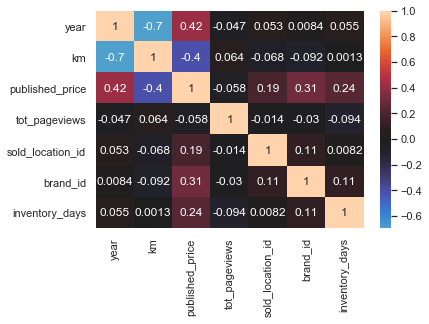

In [8]:
corr = car_description[['year', 'km', 'sku', 'published_price','tot_pageviews','sold_location_id', 'brand_id', 'version', 'accepted_offer_type','color','inventory_days']].corr()
sns.heatmap(corr, center=0,  annot=True)

Text(0.5, 1.0, 'Histogram of inventory days')

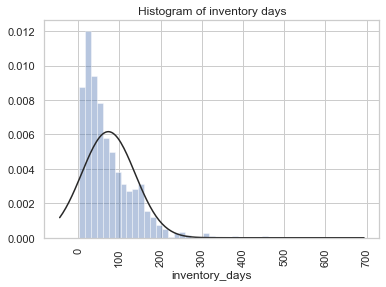

In [9]:
## histogram plot of price
#sns.distplot(houses['price'],fit=stats.laplace, kde=False)
sns.distplot(car_description['inventory_days'],fit=stats.norm, kde=False)
sns.set(color_codes=True)
plt.xticks(rotation=90)
plt.title("Histogram of inventory days")

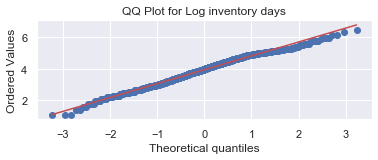

Text(0.5, 1.0, 'Histogram of Log Inventory days')

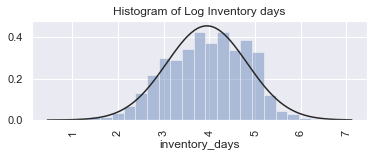

In [10]:
## QQ plot of inventroy days
plt.subplot(2,1,1)
stats.probplot(np.log(car_description['inventory_days']), dist = "norm", plot = plt)
plt.title("QQ Plot for Log inventory days")
plt.show()
plt.subplot(2,1,2)
sns.distplot(np.log(car_description['inventory_days']),fit=stats.norm, kde=False)
sns.set(color_codes=True)
plt.xticks(rotation=90)
plt.title("Histogram of Log Inventory days")

In [11]:
price,fitted_lambda = stats.boxcox(car_description['inventory_days'])
round(fitted_lambda,2)

0.11

C:\Users\edg19\Anaconda3\envs\case_1.1\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


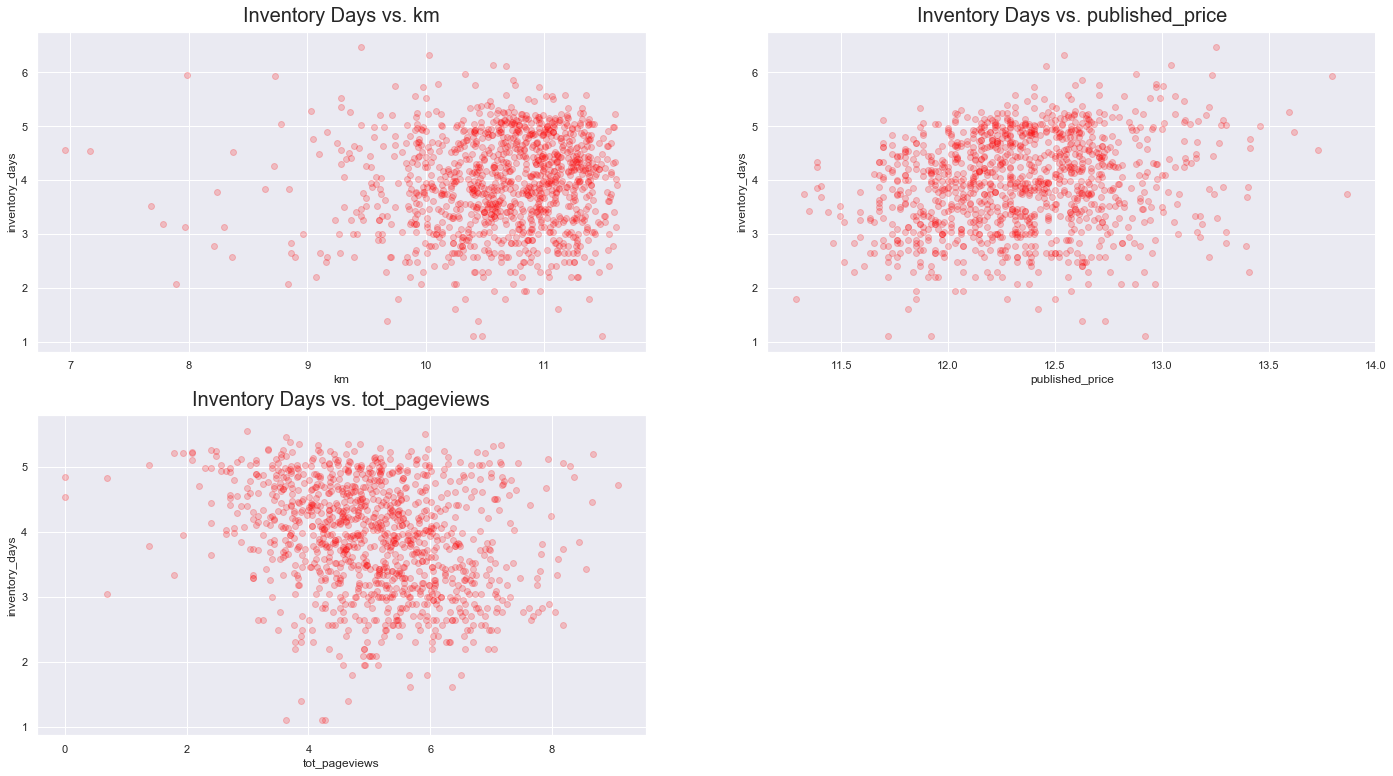

In [12]:
# Numeric non-catgorical features
plt.figure(figsize=(24,20))
varstolook = ['km', 'published_price','tot_pageviews']
for i,feature in enumerate(varstolook):
    plt.subplot(3,2,i+1)
    colvalues = np.log(car_description[feature])
    plt.scatter(colvalues.values, np.log(car_description.inventory_days.values), alpha=0.20, edgecolor=None, color='red')
    plt.xlabel(feature)
    plt.ylabel('inventory_days')
    plt.title("Inventory Days vs. " + feature, fontsize=20, verticalalignment='bottom');

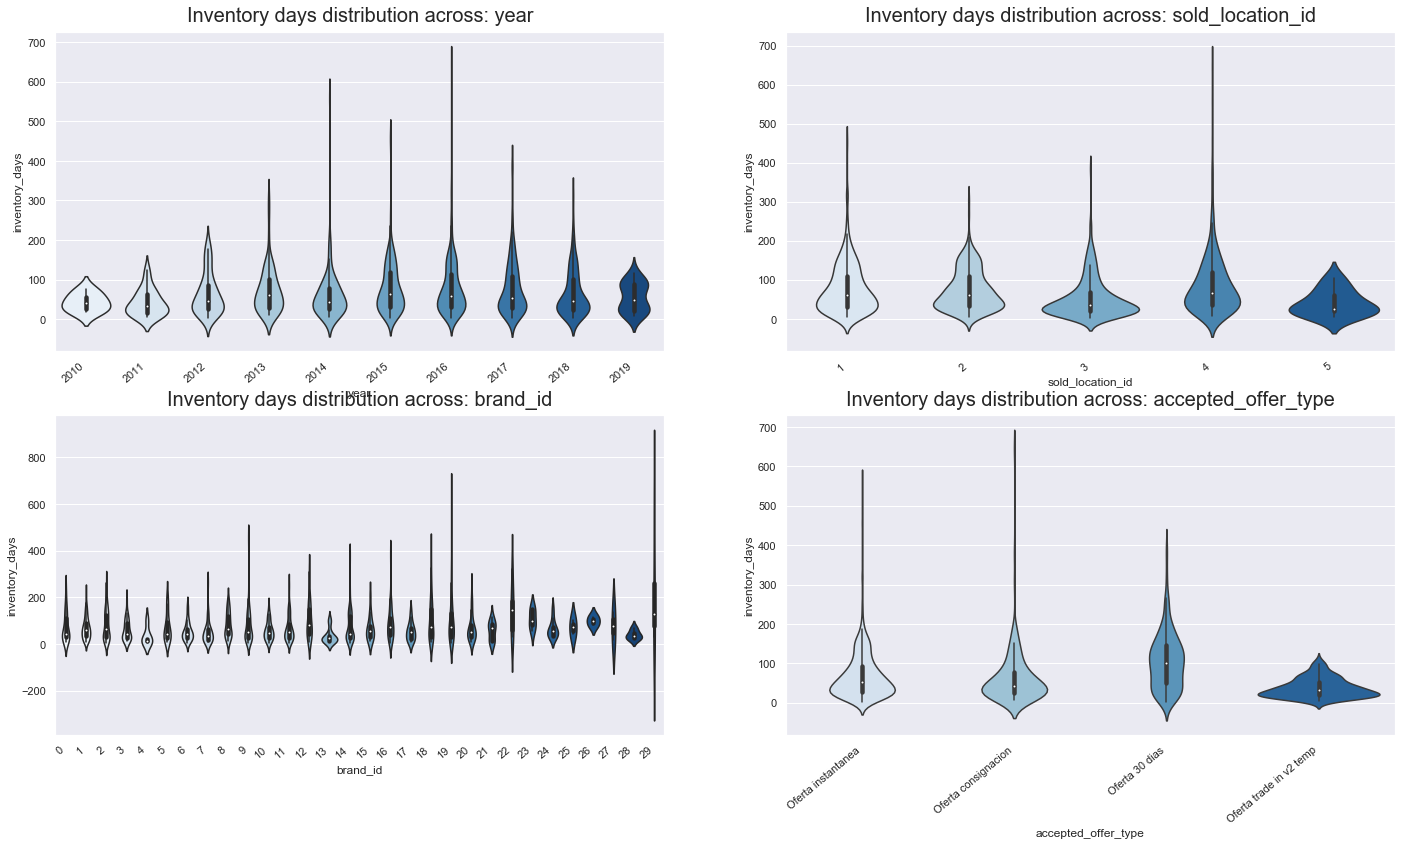

In [13]:
# Numeric categorical features
plt.figure(figsize=(24,20))
varstolook = ['year','sold_location_id', 'brand_id', 'accepted_offer_type']
for i,feature in enumerate(varstolook):
    plt.subplot(3,2,i+1)
    pl2 = sns.violinplot(x=feature, y = "inventory_days", data = car_description, palette="Blues")
    pl2.set_xticklabels(pl2.get_xticklabels(), rotation=40, ha="right");
    plt.title("Inventory days distribution across: " + feature, fontsize=20, verticalalignment='bottom');

### Error Functions

In [14]:
## RMSE

def RMSE(prediction,true_values):
    
    return np.sqrt(                                                          # Root
            np.mean(                                                      # Mean
                np.square(                                                # Squared
                         prediction-true_values                           # Error
                )
            )
        )
 
## MAPE
def MAPE(prediction,true_value):
    return np.mean(                                           # Mean
        np.abs(                                               # Absolute
               (prediction-true_value)/true_value             # Error
            )*100                                            # Percentage
    )

## Model 1

In [15]:
# Subset Data for model1

car_description_reg=car_description[['inventory_days','km', 'published_price','tot_pageviews','year', ##Numerical variables
                                     'location_name', 'brand_name', 'accepted_offer_type']]##Categorical variables# Encoding for non-numeric categorical variables
car_description2 = pd.get_dummies(car_description_reg, columns=['location_name', 'brand_name', 'accepted_offer_type'], drop_first=False)
#df2.replace({'waterfront': {"No":0, "Yes":1},
#             'newConstruction': {"No":0, "Yes":1},
#             'centralAir': {"No":0, "Yes":1}}, inplace=True)


In [16]:
# Ready data for multiple regression
X = car_description2.drop(['inventory_days'], axis=1)
y = np.log(car_description2[['inventory_days']].values.ravel())

# Split Train, Validation and Test Data
X_rest, X_test, y_rest, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
X_train, X_vali, y_train, y_vali = train_test_split(X_rest, y_rest, test_size=0.20, random_state=0)

In [17]:
#X_train = X_train.drop(['brand_name_Chrysler'], axis=1)
#X_vali = X_vali.drop(['brand_name_Chrysler'], axis=1)
#X_test = X_test.drop(['brand_name_Chrysler'], axis=1)

X_train.fillna(0)
X_vali.fillna(0)
X_test.fillna(0)

,km,published_price,tot_pageviews,year,location_name_ Florencia,location_name_Fortuna,location_name_Fuera de Kavak,location_name_Lerma,location_name_Santa Fe,brand_name_Acura,...,brand_name_Seat,brand_name_Smart,brand_name_Suzuki,brand_name_Toyota,brand_name_Volkswagen,brand_name_Volvo,accepted_offer_type_Oferta 30 dias,accepted_offer_type_Oferta consignacion,accepted_offer_type_Oferta instantanea,accepted_offer_type_Oferta trade in v2 temp
874,87004,199999.0,41,2014,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
427,102158,144999.0,685,2013,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
638,72830,157999.0,161,2012,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
994,35440,329999.0,614,2017,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
436,24990,304999.0,96,2018,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,65533,152999.0,181,2015,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
953,37852,304999.0,66,2017,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
630,101932,207999.0,136,2014,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1019,53796,254999.0,208,2015,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


### Normilize Numerical Data

In [18]:
# Function Normalize
# Input = df, DataFrame we are interested in normalizing
# This is the Min/Max scaling method 

#varstolook = ['km', 'published_price','tot_pageviews']
  
#for i,feature_name in enumerate(varstolook):
#    mean_val = X_train[feature_name].mean()
#    std_val = X_train[feature_name].std()
#    X_train[feature_name] = (X_train[feature_name] - mean_val) / std_val

#for i,feature_name in enumerate(varstolook):
#    mean_val = X_vali[feature_name].mean()
#    std_val = X_vali[feature_name].std()
#    X_vali[feature_name] = (X_vali[feature_name] - mean_val) / std_val

#for i,feature_name in enumerate(varstolook):
#    mean_val = X_test[feature_name].mean()
#    std_val = X_test[feature_name].std()
#    X_test[feature_name] = (X_test[feature_name] - mean_val) / std_val
    



In [19]:
# Fit multiple linear regression to training data
#model_linear = sm.OLS(y_train, sm.add_constant(X_train))
model_linear = sm.OLS(y_train, X_train)
model_1 = model_linear.fit()
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     5.629
Date:                Sat, 23 May 2020   Prob (F-statistic):           2.99e-22
Time:                        23:20:30   Log-Likelihood:                -832.54
No. Observations:                 722   AIC:                             1743.
Df Residuals:                     683   BIC:                             1922.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

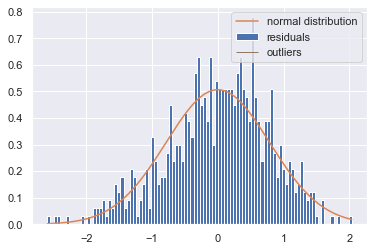

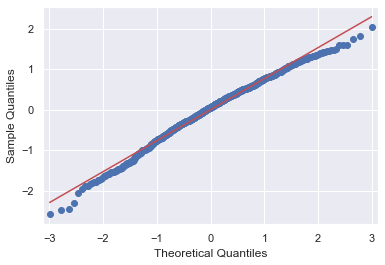

In [20]:
plt.hist(model_1.resid, 
    density=True,     # the histogram integrates to 1 
                      # (so it can be compared to the normal distribution)
    bins=100,         #  draw a histogram with 100 bins of equal width
    label="residuals" # label for legend
    )
# now plot the normal distribution for comparison
xx = np.linspace(model_1.resid.min(), model_1.resid.max(), num=1000)
plt.plot(xx, scipy.stats.norm.pdf(xx, loc=0.0, scale=np.sqrt(model_1.scale)),
    label="normal distribution")
outliers = np.abs(model_1.resid)>4*np.sqrt(model_1.scale)
sns.rugplot(model_1.resid[outliers],
            color="C5", # otherwise the rugplot has the same color as the histogram
            label="outliers")
plt.legend(loc="upper right");

sm.qqplot(model_1.resid, line="s");

In [21]:
print("AIC",model_1.aic)
print("R2",model_1.rsquared)
print("RMSE", RMSE(np.exp(model_1.predict(X_test)) ,np.exp(y_test)))
print("MAPE ", MAPE(np.exp(model_1.predict(X_test)) ,np.exp(y_test)))

AIC 1743.0873217892183
R2 0.23847761853016425
RMSE 88.26823986111232
MAPE  90.28761879315515


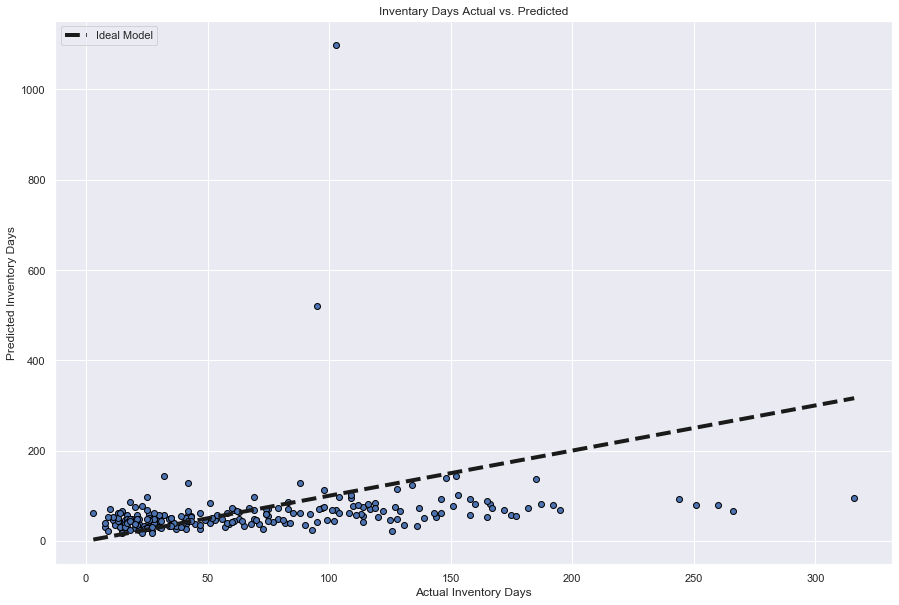

In [22]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(np.exp(y_test), np.exp(model_1.predict(X_test)), edgecolors=(0, 0, 0))
ax.plot([np.exp(y_test).min(), np.exp(y_test).max()], [np.exp(y_test).min(), np.exp(y_test).max()], 
        'k--', lw=4,label='Ideal Model')
ax.set_xlabel('Actual Inventory Days')
ax.set_ylabel('Predicted Inventory Days')
ax.set_title('Inventary Days Actual vs. Predicted')
plt.legend(loc='upper left')
plt.show()

## Model_2

In [23]:
# Subset Data for model2

car_description_outliers = car_description.drop(car_description[car_description['inventory_days']<=100].index)

car_description_reg=car_description_outliers[['inventory_days','km', 'published_price']]##

#car_description2 = pd.get_dummies(car_description_reg, columns=['location_name'], drop_first=False)
car_description2=car_description_reg

# Ready data for multiple regression
X = car_description2.drop(['inventory_days'], axis=1)
y = np.log(car_description2[['inventory_days']].values.ravel())

# Split Train, Validation and Test Data
X_rest, X_test, y_rest, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
X_train, X_vali, y_train, y_vali = train_test_split(X_rest, y_rest, test_size=0.20, random_state=0)


X_train.fillna(0)
X_vali.fillna(0)
X_test.fillna(0)

,km,published_price
410,37180,132999.0
523,44465,214999.0
64,59900,174999.0
891,26034,199999.0
492,38438,237999.0
255,21546,399999.0
855,72879,142999.0
651,29413,199999.0
734,30000,289999.0
874,87004,199999.0


In [24]:
# Fit multiple linear regression to training data
#model_linear = sm.OLS(y_train, sm.add_constant(X_train))
model_linear = sm.OLS(y_train, X_train)
model_2 = model_linear.fit()
print(model_2.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.950
Model:                            OLS   Adj. R-squared (uncentered):              0.950
Method:                 Least Squares   F-statistic:                              1789.
Date:                Sat, 23 May 2020   Prob (F-statistic):                   1.23e-122
Time:                        23:20:32   Log-Likelihood:                         -290.02
No. Observations:                 189   AIC:                                      584.0
Df Residuals:                     187   BIC:                                      590.5
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

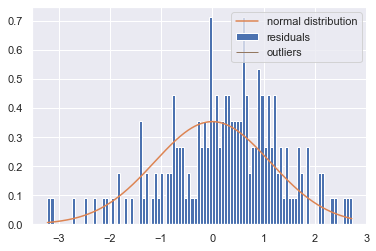

In [25]:
plt.hist(model_2.resid, 
    density=True,     # the histogram integrates to 1 
                      # (so it can be compared to the normal distribution)
    bins=100,         #  draw a histogram with 100 bins of equal width
    label="residuals" # label for legend
    )
# now plot the normal distribution for comparison
xx = np.linspace(model_2.resid.min(), model_2.resid.max(), num=1000)
plt.plot(xx, scipy.stats.norm.pdf(xx, loc=0.0, scale=np.sqrt(model_2.scale)),
    label="normal distribution")
outliers = np.abs(model_2.resid)>4*np.sqrt(model_2.scale)
sns.rugplot(model_2.resid[outliers],
            color="C5", # otherwise the rugplot has the same color as the histogram
            label="outliers")
plt.legend(loc="upper right");

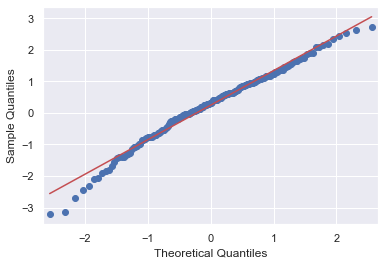

In [26]:
sm.qqplot(model_2.resid, line="s");

In [27]:
print("AIC",model_2.aic)
print("R2",model_2.rsquared)
print("RMSE", RMSE(np.exp(model_2.predict(X_test)) ,np.exp(y_test)))
print("MAPE ", MAPE(np.exp(model_2.predict(X_test)) ,np.exp(y_test)))

AIC 584.0469196750353
R2 0.9503251257549377
RMSE 1712.6026348069179
MAPE  218.78110101064496


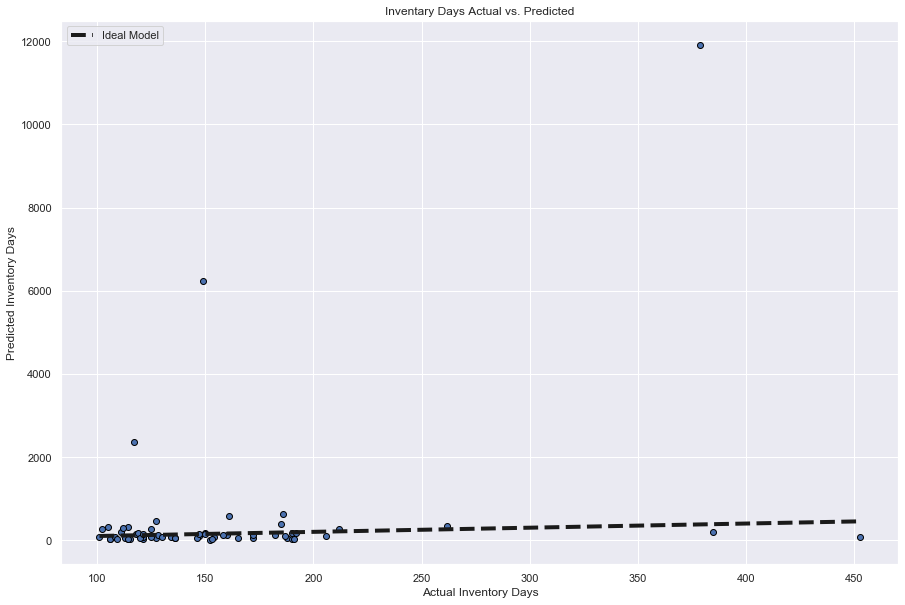

In [28]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(np.exp(y_test), np.exp(model_2.predict(X_test)), edgecolors=(0, 0, 0))
ax.plot([np.exp(y_test).min(), np.exp(y_test).max()], [np.exp(y_test).min(), np.exp(y_test).max()], 
        'k--', lw=4,label='Ideal Model')
ax.set_xlabel('Actual Inventory Days')
ax.set_ylabel('Predicted Inventory Days')
ax.set_title('Inventary Days Actual vs. Predicted')
plt.legend(loc='upper left')
plt.show()

## Model 3

### One model for each showroom

In [31]:
car_description['location_name'].unique()

array([' Florencia', 'Santa Fe', 'Fuera de Kavak', 'Fortuna', 'Lerma'],
      dtype=object)

---------------------------------------------------
------------------  Florencia ---------------------
---------------------------------------------------
AIC 290.1385065871069
R2 0.9255071796739587
RMSE 23.58042413266202
MAPE  70.74263130604325


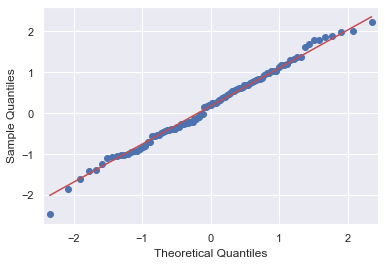

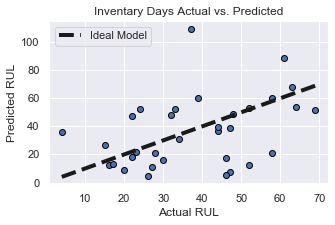

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.926
Model:                            OLS   Adj. R-squared (uncentered):              0.924
Method:                 Least Squares   F-statistic:                              639.8
Date:                Sat, 23 May 2020   Prob (F-statistic):                    8.20e-59
Time:                        23:22:28   Log-Likelihood:                         -143.07
No. Observations:                 105   AIC:                                      290.1
Df Residuals:                     103   BIC:                                      295.4
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

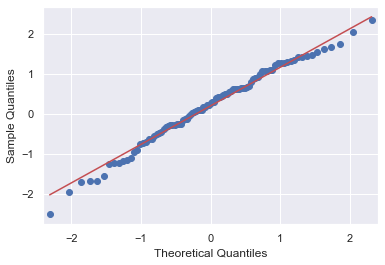

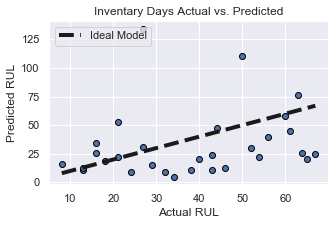

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.921
Model:                            OLS   Adj. R-squared (uncentered):              0.919
Method:                 Least Squares   F-statistic:                              539.5
Date:                Sat, 23 May 2020   Prob (F-statistic):                    6.75e-52
Time:                        23:22:29   Log-Likelihood:                         -133.11
No. Observations:                  95   AIC:                                      270.2
Df Residuals:                      93   BIC:                                      275.3
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

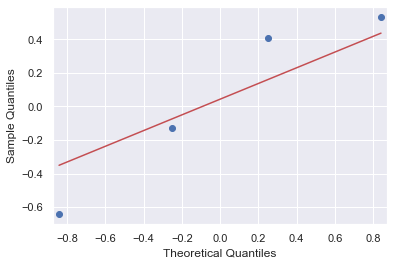

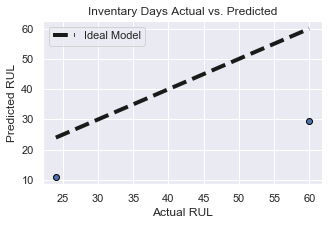

C:\Users\edg19\Anaconda3\envs\case_1.1\lib\site-packages\statsmodels\stats\stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.970
Model:                            OLS   Adj. R-squared (uncentered):              0.939
Method:                 Least Squares   F-statistic:                              31.90
Date:                Sat, 23 May 2020   Prob (F-statistic):                      0.0304
Time:                        23:22:30   Log-Likelihood:                         -2.6540
No. Observations:                   4   AIC:                                      9.308
Df Residuals:                       2   BIC:                                      8.081
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

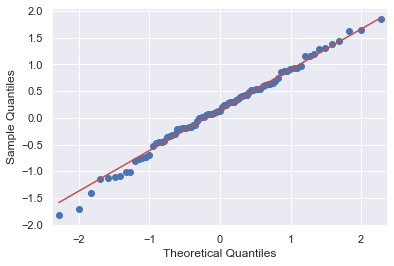

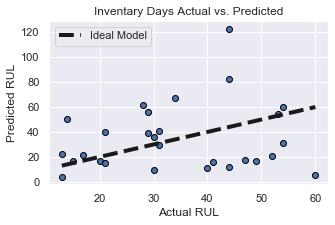

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.951
Model:                            OLS   Adj. R-squared (uncentered):              0.950
Method:                 Least Squares   F-statistic:                              826.6
Date:                Sat, 23 May 2020   Prob (F-statistic):                    1.98e-56
Time:                        23:22:31   Log-Likelihood:                         -101.04
No. Observations:                  87   AIC:                                      206.1
Df Residuals:                      85   BIC:                                      211.0
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

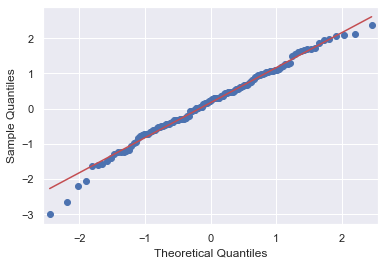

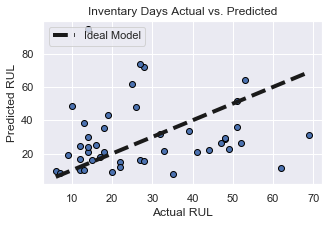

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.904
Model:                            OLS   Adj. R-squared (uncentered):              0.903
Method:                 Least Squares   F-statistic:                              652.6
Date:                Sat, 23 May 2020   Prob (F-statistic):                    4.56e-71
Time:                        23:22:32   Log-Likelihood:                         -199.91
No. Observations:                 140   AIC:                                      403.8
Df Residuals:                     138   BIC:                                      409.7
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

In [32]:
showroomlist =[' Florencia', 'Santa Fe', 'Fuera de Kavak', 'Fortuna', 'Lerma']
  
for i,showroom in enumerate(showroomlist):
    car_description_showroom = car_description.drop(car_description[car_description['location_name']!=showroom].index)
    
    #mean_val = car_description_showroom['inventory_days'].mean()
    #std_val = car_description_showroom['inventory_days'].std()
    #a=mean_val+2*std_val
    
    ###### Filter inventory days grater dan 70 #############
    car_description_showroom = car_description_showroom.drop(car_description_showroom[car_description_showroom['inventory_days']>=70].index)
    
    

    car_description_reg=car_description_showroom[['inventory_days','km', 'published_price' ##Numerical variables
                                                ]]##Categorical variables# Encoding for non-numeric categorical variables


    #car_description2 = pd.get_dummies(car_description_reg, columns=['accepted_offer_type','brand_name'], drop_first=False)
    car_description2=car_description_reg


    # Ready data for multiple regression
    X = car_description2.drop(['inventory_days'], axis=1)
    y = np.log(car_description2[['inventory_days']].values.ravel())

    # Split Train, Validation and Test Data
    X_rest, X_test, y_rest, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
    X_train, X_vali, y_train, y_vali = train_test_split(X_rest, y_rest, test_size=0.20, random_state=0)


    X_train.fillna(0)
    X_vali.fillna(0)
    X_test.fillna(0)


    ######### LINEAR MODEL ###############
    model_linear = sm.OLS(y_train, X_train)
    model_i = model_linear.fit()
    
    print("---------------------------------------------------")
    print("------------------",showroom,"---------------------")
    print("---------------------------------------------------")
    print("AIC",model_i.aic)
    print("R2",model_i.rsquared)
    print("RMSE", RMSE(np.exp(model_i.predict(X_test)) ,np.exp(y_test)))
    print("MAPE ", MAPE(np.exp(model_i.predict(X_test)) ,np.exp(y_test)))
    
    
    sm.qqplot(model_i.resid, line="s");
    
    fig, ax = plt.subplots(figsize=(5,3))
    ax.scatter(np.exp(y_test), np.exp(model_i.predict(X_test)), edgecolors=(0, 0, 0))
    ax.plot([np.exp(y_test).min(), np.exp(y_test).max()], [np.exp(y_test).min(), np.exp(y_test).max()], 
            'k--', lw=4,label='Ideal Model')
    ax.set_xlabel('Actual RUL')
    ax.set_ylabel('Predicted RUL')
    ax.set_title('Inventary Days Actual vs. Predicted')
    plt.legend(loc='upper left')
    plt.show()
       
    print(model_i.summary())

## Model 4

### Split data into two. One for cars with inventory days less than 70 and the other for cars greater than 70 days of inventory


--------------------------------------------------------------
------------------ Grater than 70 days ---------------------
--------------------------------------------------------------
AIC 905.644297749118
R2 0.9396840673395396
RMSE 330.4003217925861
MAPE  132.46654613628132


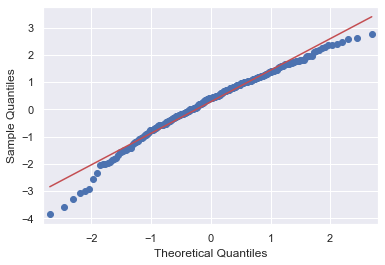

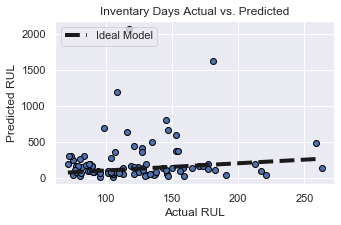

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.904
Model:                            OLS   Adj. R-squared (uncentered):              0.903
Method:                 Least Squares   F-statistic:                              652.6
Date:                Sat, 23 May 2020   Prob (F-statistic):                    4.56e-71
Time:                        23:22:33   Log-Likelihood:                         -199.91
No. Observations:                 140   AIC:                                      403.8
Df Residuals:                     138   BIC:                                      409.7
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

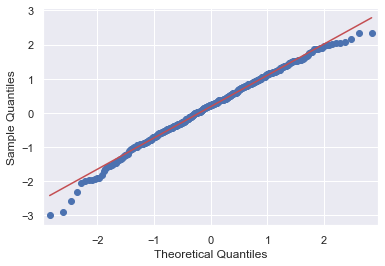

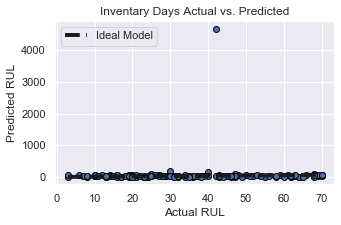

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.904
Model:                            OLS   Adj. R-squared (uncentered):              0.903
Method:                 Least Squares   F-statistic:                              652.6
Date:                Sat, 23 May 2020   Prob (F-statistic):                    4.56e-71
Time:                        23:22:33   Log-Likelihood:                         -199.91
No. Observations:                 140   AIC:                                      403.8
Df Residuals:                     138   BIC:                                      409.7
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

In [33]:
    car_description_greater_days = car_description.drop(car_description[car_description['inventory_days']<=70].index)

    car_description2=car_description_greater_days[['inventory_days','km', 'published_price' ##Numerical variables
                                                ]]##Categorical variables# Encoding for non-numeric categorical variables

    # Ready data for multiple regression
    X = car_description2.drop(['inventory_days'], axis=1)
    y = np.log(car_description2[['inventory_days']].values.ravel())

    # Split Train, Validation and Test Data
    X_rest, X_test, y_rest, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
    X_train, X_vali, y_train, y_vali = train_test_split(X_rest, y_rest, test_size=0.20, random_state=0)


    X_train.fillna(0)
    X_vali.fillna(0)
    X_test.fillna(0)


    ######### LINEAR MODEL Greater than 70 inventory days ###############
    model_linear = sm.OLS(y_train, X_train)
    model_4 = model_linear.fit()
    
    print("--------------------------------------------------------------")
    print("------------------","Grater than 70 days","---------------------")
    print("--------------------------------------------------------------")
    print("AIC",model_4.aic)
    print("R2",model_4.rsquared)
    print("RMSE", RMSE(np.exp(model_4.predict(X_test)) ,np.exp(y_test)))
    print("MAPE ", MAPE(np.exp(model_4.predict(X_test)) ,np.exp(y_test)))
    
    
    sm.qqplot(model_4.resid, line="s");
    
    fig, ax = plt.subplots(figsize=(5,3))
    ax.scatter(np.exp(y_test), np.exp(model_4.predict(X_test)), edgecolors=(0, 0, 0))
    ax.plot([np.exp(y_test).min(), np.exp(y_test).max()], [np.exp(y_test).min(), np.exp(y_test).max()], 
            'k--', lw=4,label='Ideal Model')
    ax.set_xlabel('Actual RUL')
    ax.set_ylabel('Predicted RUL')
    ax.set_title('Inventary Days Actual vs. Predicted')
    plt.legend(loc='upper left')
    plt.show()
        
    print(model_i.summary())
    
    
    
    ######### LINEAR MODEL Less than 70 inventory days ###############
    
    
    car_description_less_days = car_description.drop(car_description[car_description['inventory_days']>70].index)

    car_description2=car_description_less_days[['inventory_days','km', 'published_price' ##Numerical variables
                                                ]]##Categorical variables# Encoding for non-numeric categorical variables

    # Ready data for multiple regression
    X = car_description2.drop(['inventory_days'], axis=1)
    y = np.log(car_description2[['inventory_days']].values.ravel())

    # Split Train, Validation and Test Data
    X_rest, X_test, y_rest, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
    X_train, X_vali, y_train, y_vali = train_test_split(X_rest, y_rest, test_size=0.20, random_state=0)


    X_train.fillna(0)
    X_vali.fillna(0)
    X_test.fillna(0)
    
    
    model_linear = sm.OLS(y_train, X_train)
    model_4 = model_linear.fit()
    
    print("--------------------------------------------------------------")
    print("------------------","Less than 70 days","---------------------")
    print("--------------------------------------------------------------")
    print("AIC",model_4.aic)
    print("R2",model_4.rsquared)
    print("RMSE", RMSE(np.exp(model_4.predict(X_test)) ,np.exp(y_test)))
    print("MAPE ", MAPE(np.exp(model_4.predict(X_test)) ,np.exp(y_test)))
    
    
    sm.qqplot(model_4.resid, line="s");
    
    fig, ax = plt.subplots(figsize=(5,3))
    ax.scatter(np.exp(y_test), np.exp(model_4.predict(X_test)), edgecolors=(0, 0, 0))
    ax.plot([np.exp(y_test).min(), np.exp(y_test).max()], [np.exp(y_test).min(), np.exp(y_test).max()], 
            'k--', lw=4,label='Ideal Model')
    ax.set_xlabel('Actual RUL')
    ax.set_ylabel('Predicted RUL')
    ax.set_title('Inventary Days Actual vs. Predicted')
    plt.legend(loc='upper left')
    plt.show()
    
    
    
    print(model_i.summary())

    

## Regularization

In [34]:
# Subset Data for Regularization model

car_description_model = car_description.drop(car_description[car_description['inventory_days']>=100].index)
    


car_description_reg=car_description_model[['inventory_days','km', 'published_price','tot_pageviews', ##Numerical variables
                                     'location_name', 'brand_name', 'accepted_offer_type','color']]##Categorical variables# Encoding for non-numeric categorical variables
car_description2 = pd.get_dummies(car_description_reg, columns=['location_name', 'brand_name', 'accepted_offer_type','color'], drop_first=False)

#car_description2 = pd.get_dummies(car_description_reg, columns=['location_name'], drop_first=False)
#car_description2=car_description_reg

# Ready data for multiple regression
X = car_description2.drop(['inventory_days'], axis=1)
y = np.log(car_description2[['inventory_days']].values.ravel())

# Split Train, Validation and Test Data
X_rest, X_test, y_rest, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
X_train, X_vali, y_train, y_vali = train_test_split(X_rest, y_rest, test_size=0.20, random_state=0)


X_train.fillna(0)
X_vali.fillna(0)
X_test.fillna(0)

,km,published_price,tot_pageviews,location_name_ Florencia,location_name_Fortuna,location_name_Fuera de Kavak,location_name_Lerma,location_name_Santa Fe,brand_name_Acura,brand_name_Audi,...,color_negro,color_negro brillante,color_negro total,color_plata,color_plata diamante,color_plata estelar,color_plata reflex metalico,color_rojo brillante,color_rojo emocion,color_rojo marte
1123,43927,424999.0,57,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
134,78500,152999.0,423,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9,50220,129999.0,891,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
359,59312,174999.0,1054,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
835,24158,377999.0,684,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,21576,202999.0,522,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
718,44100,244999.0,41,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1005,50591,259999.0,40,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
887,19156,187999.0,40,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
# Loop through different lambda values
lambdas = np.arange(0.1, 100.0, 0.1)

coefs = []
mse_train = []
mse_vali = []
for l in lambdas:
    ridge = linear_model.Lasso(alpha=l, fit_intercept=True)
    ridge.fit(X_train, y_train)
    mse_train.append(mean_squared_error(y_train, ridge.predict(X_train))) # train data
    mse_vali.append(mean_squared_error(y_vali, ridge.predict(X_vali))) # validation data

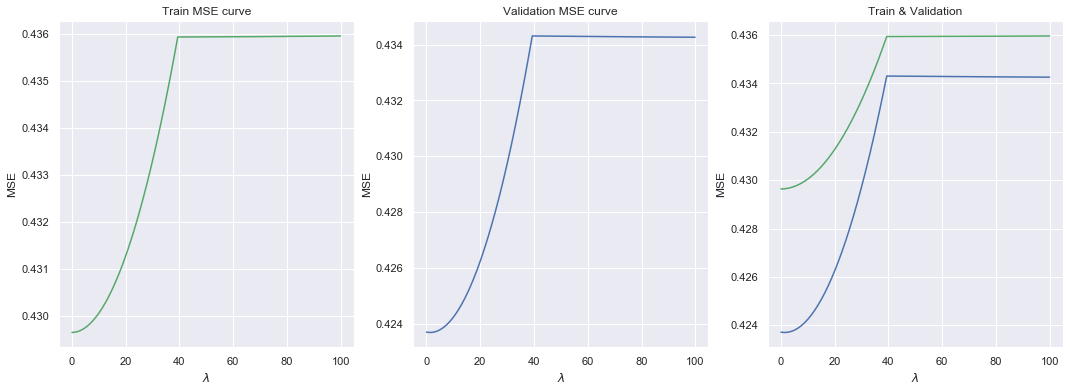

In [36]:
# Plot results
fig, ax1 = plt.subplots(1,3,figsize=(18,6))

ax1[0].plot(lambdas, mse_train, 'g-')
ax1[0].set_title('Train MSE curve')

ax1[1].plot(lambdas, mse_vali, 'b-')
ax1[1].set_title('Validation MSE curve')

#Place the two plots into one
ax1[2].plot(lambdas, mse_train, 'g-')
ax1[2].plot(lambdas, mse_vali, 'b-')
ax1[2].set_title('Train & Validation')


for ax in ax1.flat:
    ax.set_xlabel('$\lambda$')
    ax.set_ylabel('MSE')
    
    
plt.show()

In [37]:
# Fitting the model
model_l2 = linear_model.Lasso(alpha=13, fit_intercept=True) # higher alpha for stronger regularization
results_l2 = model_l2.fit(X_train, y_train)

sorted(zip(X_train.columns, results_l2.coef_), key=lambda x: x[1])

[('tot_pageviews', -0.00010689156355282004),
 ('location_name_ Florencia', 0.0),
 ('location_name_Fortuna', 0.0),
 ('location_name_Fuera de Kavak', -0.0),
 ('location_name_Lerma', -0.0),
 ('location_name_Santa Fe', 0.0),
 ('brand_name_Acura', -0.0),
 ('brand_name_Audi', 0.0),
 ('brand_name_BMW', -0.0),
 ('brand_name_Buick', 0.0),
 ('brand_name_Cadillac', 0.0),
 ('brand_name_Chevrolet', -0.0),
 ('brand_name_Chrysler', 0.0),
 ('brand_name_Dodge', -0.0),
 ('brand_name_Fiat', 0.0),
 ('brand_name_Ford', -0.0),
 ('brand_name_GMC', 0.0),
 ('brand_name_Honda', 0.0),
 ('brand_name_Hyundai', -0.0),
 ('brand_name_Infiniti', 0.0),
 ('brand_name_Jeep', -0.0),
 ('brand_name_KIA', 0.0),
 ('brand_name_Lincoln', 0.0),
 ('brand_name_Mazda', 0.0),
 ('brand_name_Mercedes Benz', 0.0),
 ('brand_name_Mini', 0.0),
 ('brand_name_Mitsubishi', -0.0),
 ('brand_name_Nissan', 0.0),
 ('brand_name_Peugeot', -0.0),
 ('brand_name_Renault', 0.0),
 ('brand_name_Seat', 0.0),
 ('brand_name_Smart', -0.0),
 ('brand_name_Suzu